# Predict slab dip

Predict the average slab dip, $\theta_{\mathrm{av}}$, of subducting oceanic lithosphere using the following relation,

$$
\theta_{\mathrm{av}} = A (v_c + v_t) h_{\mathrm{plate}} + B
$$

where $h_{\mathrm{plate}}$ is the thickness of the subducting plate calculated by plate models of lithospheric cooling (from [Grose, 2012](https://doi.org/10.1016/j.epsl.2012.03.037)), $v_c$ is the convergence velocity, $v_t$ is the rate of trench migration, and $A$ and $B$ are coefficients obtained from a weighted linear regression.
Using the present-day configuration of subduction boundaries and slab dips obtained from the Slab2 model ([Hayes _et al._, 2018](https://doi.org/10.1126/science.aat4723)), we obtain $A = 0.006$ and $B = 8$ with standard deviations of $\sigma_A = 0.001$ and $\sigma_B = 5$.


## Dependencies

To run this notebook some dependencies are required:

- [pygplates](https://www.gplates.org/download/)
- [PlateTectonicTools](https://github.com/EarthByte/PlateTectonicTools/tree/master/ptt)
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/installing.html) (for mapping)
- [netCDF4](https://pypi.org/project/netCDF4/) (to extract age grids of the seafloor)


## Data packages

A plate reconstruction and corresponding age grids of the seafloor are required to predict slab dip. These may be downloaded from https://www.earthbyte.org/gplates-2-3-software-and-data-sets/

The slab dip calculation has been tested on [Clennett _et al._ (2020)](https://doi.org/10.1029/2020GC009117) and [Müller _et al._ (2019)](https://doi.org/10.1029/2018TC005462) plate reconstructions but should also work fine for other plate reconstructions.


#### References

- Grose, C. J. (2012). Properties of oceanic lithosphere: Revised plate cooling model predictions. Earth and Planetary Science Letters, 333–334, 250–264. https://doi.org/10.1016/j.epsl.2012.03.037
- Hayes, G. P., Moore, G. L., Portner, D. E., Hearne, M., Flamme, H., Furtney, M., & Smoczyk, G. M. (2018). Slab2, a comprehensive subduction zone geometry model. Science, 362(6410), 58–61. https://doi.org/10.1126/science.aat4723
- Clennett, E. J., Sigloch, K., Mihalynuk, M. G., Seton, M., Henderson, M. A., Hosseini, K., et al. (2020). A Quantitative Tomotectonic Plate Reconstruction of Western North America and the Eastern Pacific Basin. Geochemistry, Geophysics, Geosystems, 21(8), 1–25. https://doi.org/10.1029/2020GC009117
- Müller, R. D., Zahirovic, S., Williams, S. E., Cannon, J., Seton, M., Bower, D. J., et al. (2019). A Global Plate Model Including Lithospheric Deformation Along Major Rifts and Orogens Since the Triassic. Tectonics, 38(6), 1884–1907. https://doi.org/10.1029/2018TC005462

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import pygplates
import numpy as np
import csv
import sys

import cartopy.crs as ccrs

import ptt
import ptt.subduction_convergence

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from scipy.stats import gaussian_kde
from scipy.spatial import cKDTree
from scipy import ndimage
import netCDF4
import stripy

import warnings
import os, glob

In [2]:
# Input rotation and topology files.
agegrid_dir = "path/to/agegrids/"
input_directory = "path/to/reconstruction/files"

rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
rotation_model = pygplates.RotationModel(rotation_filenames)

coastlines = input_directory+"StaticGeometries/Coastlines/Global_coastlines_2019_v1_low_res.shp"
continents = input_directory+"StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2019_v1.shp"

topology_filenames = glob.glob(os.path.join(input_directory, '*.gpml'))
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    if "Inactive" not in topology_filename:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )


# Tessellate the subduction zones to 0.5 degrees.
tessellation_threshold_radians = np.radians(0.05)

extent_globe = [-180,180,-90,90]
agegrid_filename = "Muller_etal_2019_Tectonics_v2.0_AgeGrid-{:.0f}.nc"

In [3]:
def fill_ndimage(data,invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid')
    by the value of the nearest valid data cell
    """
    from scipy.ndimage import distance_transform_edt
    masked_array = hasattr(data, "fill_value")
    if masked_array:
        mask_fill_value = data.data == data.fill_value
        data = data.data.copy()
        data[mask_fill_value] = np.nan
    else:
        data = data.copy()

    if invalid is None:
        invalid = np.isnan(data)
        if masked_array:
            invalid += mask_fill_value
    ind = distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

def read_netcdf_grid(filename):
    """
    Read in a netCDF file and re-align from -180 to 180 degrees
    
    Parameters
    ----------
    filename : str
        path to netCDF file
    return_grids : bool
        optionally return lon, lat arrays associated with grid
    resample : tuple
        optionally resample grid, pass spacing in X and Y direction as a tuple
        e.g. resample=(spacingX, spacingY)
    """
    import netCDF4
    
    # open netCDF file and re-align from -180, 180 degrees
    with netCDF4.Dataset(filename, 'r') as cdf:
        cdf_grid = cdf["z"]
        try:
            cdf_lon = cdf['lon'][:]
            cdf_lat = cdf['lat'][:]
        except:
            cdf_lon = cdf['x'][:]
            cdf_lat = cdf['y'][:]
            
        cdf_lon_mask = cdf_lon[:] > 180
        
        if cdf_lon_mask.any():
            cdf_grid_z = np.hstack([cdf_grid[:,cdf_lon_mask], cdf_grid[:,~cdf_lon_mask]])
            cdf_lon = np.hstack([cdf_lon[cdf_lon_mask], cdf_lon[~cdf_lon_mask]])
        else:
            cdf_grid_z = cdf_grid[:]

    return cdf_grid_z
    
def sample_grid(lon, lat, grid, extent):
    from scipy import interpolate
    
    rgi = interpolate.RegularGridInterpolator((np.linspace(extent[2], extent[3], grid.shape[0]),
                                               np.linspace(extent[0], extent[1], grid.shape[1])),
                                               grid)
    return rgi(np.c_[lat, lon])                 

def plate_temp(age, z, PLATE_THICKNESS) :
    "Computes the temperature in a cooling plate for age = t\
    and at a depth = z."

    KAPPA = 0.804e-6
    T_MANTLE = 1350.0
    T_SURFACE = 0.0

    sine_arg = np.pi * z / PLATE_THICKNESS
    exp_arg = -KAPPA * np.pi * np.pi * age / (PLATE_THICKNESS * PLATE_THICKNESS)
    k = np.ones_like(age)*np.arange(1, 20).reshape(-1,1)
    cumsum = ( np.sin(k * sine_arg) * np.exp(k*k*exp_arg)/k ).sum(axis=0)

    return T_SURFACE + 2.0 * cumsum * (T_MANTLE - T_SURFACE)/np.pi + (T_MANTLE - T_SURFACE) * z/PLATE_THICKNESS

def plate_isotherm_depth(age, temp=1350.0):
    "Computes the depth to the temp - isotherm in a cooling plate mode.\
    Solution by iteration. By default the plate thickness is 125 km as\
    in Parsons/Sclater."

    PLATE_THICKNESS = 125e3
    
    z = 0.0 # starting depth is 0
    rtol = 0.001 # error tolerance
    
    z_too_small = np.atleast_1d(np.zeros_like(age, dtype=float))
    z_too_big = np.atleast_1d(np.full_like(age, PLATE_THICKNESS, dtype=float))
    
    for i in range(20):
        zi = 0.5 * (z_too_small + z_too_big)
        ti = plate_temp (age, zi, PLATE_THICKNESS)
        t_diff = temp - ti
        z_too_big[t_diff < -rtol] = zi[t_diff < -rtol]
        z_too_small[t_diff > rtol] = zi[t_diff > rtol]
        
        if (np.abs(t_diff) < rtol).all():
            break
            
    # protect against negative ages
    zi[age <= 0] = 0
    return np.squeeze(zi)

def My2s(Ma):
    return Ma*3.1536e13


## Get kinematic data

Using `PlateTectonicTools` we extract plate kinematic data for the present-day configuration of subduction zones to calculate the dip angle of subducting slabs.

In [4]:
reconstruction_time = 0

# calculate subduction convergence
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    subduction_data = ptt.subduction_convergence.subduction_convergence(
        rotation_model,
        topology_features,
        tessellation_threshold_radians,
        reconstruction_time,
        velocity_delta_time=1,
        anchor_plate_id=0,
        output_subducting_absolute_velocity_components=True)
    subduction_data = np.vstack(subduction_data)

subduction_lon     = subduction_data[:,0]
subduction_lat     = subduction_data[:,1]
subduction_angle   = subduction_data[:,3]
subduction_norm    = subduction_data[:,7]
subduction_pid_sub = subduction_data[:,8]
subduction_pid_over= subduction_data[:,9]
subduction_length  = np.radians(subduction_data[:,6]) * pygplates.Earth.mean_radius_in_kms * 1e3 # in metres
subduction_convergence = np.fabs(subduction_data[:,2])*1e-2 * np.cos(np.radians(subduction_data[:,3]))
subduction_migration   = np.fabs(subduction_data[:,4])*1e-2 * np.cos(np.radians(subduction_data[:,5]))
subduction_plate_vel = subduction_data[:,10]

# remove entries that have "negative" subduction
# this occurs when the subduction obliquity is greater than 90 degrees
subduction_convergence = np.clip(subduction_convergence, 0, 1e99)

# sample AgeGrid
age_grid = read_netcdf_grid(agegrid_dir+agegrid_filename.format(reconstruction_time))
age_grid_filled = fill_ndimage(age_grid)
age_interp = sample_grid(subduction_lon, subduction_lat, age_grid_filled, extent_globe)
subduction_age = age_interp
thickness = plate_isotherm_depth(My2s(age_interp))


# calculate subduction volume rate - m * m * m/yr
subduction_vol_rate = thickness*subduction_length*subduction_convergence # integrated along subduction len
subduction_vol_rate *= 1e-9 # convert m^3/yr to km^3/yr


# get the ratio of convergence velocity to trench migration
vratio = (subduction_convergence + subduction_migration)/(subduction_convergence + 1e-22)
vratio[subduction_plate_vel < 0] *= -1
vratio = np.clip(vratio, 0.0, 1.0)

# calculate slab dip using coefficients a and b
coeff_a, coeff_b = 0.00639289, 8.00315437
subduction_dip = coeff_a*(subduction_convergence*vratio)*thickness + coeff_b

# calculate distance of arc to trench
d_trench = 125.0/np.tan(np.radians(subduction_dip))


print("mean plate thickness = {:.2f} m".format(thickness.mean()))
print("mean subduction segment length = {:.2f} m".format(subduction_length.mean()))
print("mean subduction convergence rate = {:.4f} m/yr".format(subduction_convergence.mean()))
print("mean subduction volume rate = {:.4f} km^3/yr".format(subduction_vol_rate.mean()))
print("total subduction volume rate = {:.4f} km^3/yr".format(subduction_vol_rate.sum()))

mean plate thickness = 121035.01 m
mean subduction segment length = 5362.52 m
mean subduction convergence rate = 0.0392 m/yr
mean subduction volume rate = 0.0259 km^3/yr
total subduction volume rate = 312.0560 km^3/yr


/tmp/ipykernel_150327/2844427801.py:91: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z_too_small = np.atleast_1d(np.zeros_like(age, dtype=np.float))
/tmp/ipykernel_150327/2844427801.py:92: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z_too_big = np.atleast_1d(np.full_like(age, PLATE_THICKNESS, dtype=np.float))


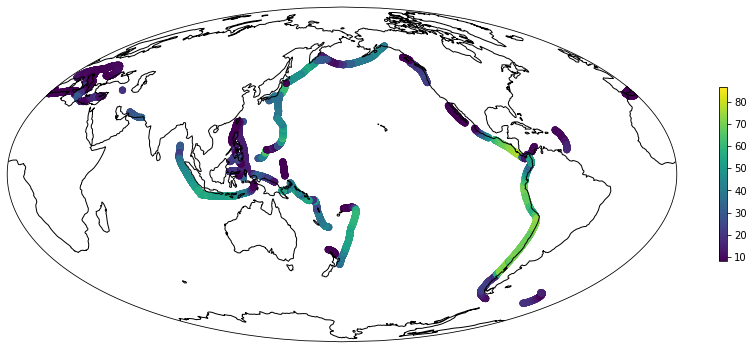

In [5]:
proj = ccrs.Mollweide(central_longitude=180)

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
ax.set_global()

sc = ax.scatter(subduction_lon, subduction_lat, c=subduction_dip, transform=ccrs.PlateCarree())

ax.coastlines()
fig.colorbar(sc, shrink=0.4)

